In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import sqlite3

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
with sqlite3.connect('../vast.db') as conn:
    cost = pd.read_sql(
        f'''
        SELECT machine_id, dph_base, timestamp FROM cost_ts        
        ''', 
        conn, 
        index_col='machine_id',
        dtype={
            'machine_id': 'uint16',
            'dph_base': 'uint16',
            'timestamp': 'uint32',            
        })

cost.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1619336 entries, 14326 to 838
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   dph_base   1619336 non-null  uint16
 1   timestamp  1619336 non-null  uint32
dtypes: uint16(1), uint32(1)
memory usage: 12.4 MB


In [4]:
df = pd.DataFrame({'dph_base': [100, 100 , 200, 200, 250, 200], 
                   'timestamp': [1, 2, 3, 1, 2, 3]},
                  # columns=['dph_base', 'timestamp'],
                  index=[32, 32, 32, 120, 120, 120])
df.index.name = 'machine_id'
df

,dph_base,timestamp
machine_id,,
32,100,1
32,100,2
32,200,3
120,200,1
120,250,2
120,200,3


In [5]:
from collections.abc import Iterable

def drop_consecutives(df, cols=None):
    if isinstance(cols, str):
        return df.loc[df[cols].shift() != df[cols]]
    else:
        mask = (df[cols].shift() != df[cols]).any(axis=1) 
        return df.loc[mask]

In [6]:
df.groupby('machine_id').apply(drop_consecutives, cols='dph_base').reset_index(level=0, drop=True)

,dph_base,timestamp
machine_id,,
32,100,1
32,200,3
120,200,1
120,250,2
120,200,3


In [7]:
cost = cost.groupby('machine_id').apply(drop_consecutives, cols='dph_base').reset_index(level=0, drop=True)
cost.info()

<class 'pandas.core.frame.DataFrame'>
Index: 398369 entries, 63 to 22982
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   dph_base   398369 non-null  uint16
 1   timestamp  398369 non-null  uint32
dtypes: uint16(1), uint32(1)
memory usage: 3.0 MB


In [8]:
with sqlite3.connect('../vast.db') as conn:
    rent = pd.read_sql(
        f'SELECT machine_id, num_gpus_rented, timestamp FROM rent_ts',
        conn,
        index_col='machine_id',
        dtype={
            'machine_id': 'uint16',
            'num_gpus_rented': 'uint8',
            'timestamp': 'uint32'
        })

rent.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2186857 entries, 14326 to 838
Data columns (total 2 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   num_gpus_rented  uint8 
 1   timestamp        uint32
dtypes: uint32(1), uint8(1)
memory usage: 14.6 MB


In [9]:
mid = 63

df = rent.loc[mid].copy()
df.num_gpus_rented = df.num_gpus_rented.shift(1)
df.timestamp -= 1

res = pd.concat([df.iloc[1:], rent.loc[mid].copy()]).sort_values(by='timestamp')
res

,num_gpus_rented,timestamp
machine_id,,
63,0.0,1697699070
63,0.0,1697717951
63,1.0,1697717952
63,1.0,1697718167
63,0.0,1697718168
...,...,...
63,1.0,1714725019
63,1.0,1714725272
63,0.0,1714725273


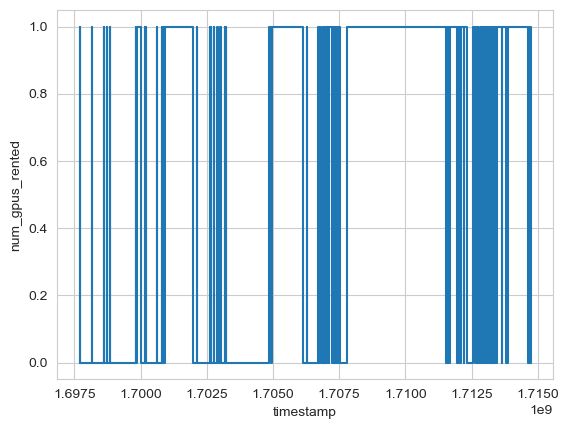

In [10]:
sns.lineplot(res, x='timestamp', y='num_gpus_rented');

In [11]:
def staircase_fill(df, col: str):
    df_ = df.copy()
    df_[col] = df_[col].shift(1, fill_value=0)
    df_.timestamp -= 1    
    res = pd.concat([df_.iloc[1:], df])
    return res

In [12]:
rent.loc[63]

,num_gpus_rented,timestamp
machine_id,,
63,0,1697699070
63,1,1697717952
63,0,1697718168
63,1,1698166394
63,0,1698166894
...,...,...
63,1,1714724032
63,0,1714724161
63,1,1714725019


In [13]:
staircase_fill(rent.loc[63], 'num_gpus_rented').sort_values(by='timestamp')

,num_gpus_rented,timestamp
machine_id,,
63,0,1697699070
63,0,1697717951
63,1,1697717952
63,1,1697718167
63,0,1697718168
...,...,...
63,1,1714725019
63,1,1714725272
63,0,1714725273


In [14]:
# df = rent.loc[63].groupby('machine_id').apply(staircase_fill, cols='num_gpus_rented').reset_index(level=0, drop=True).sort_values(by='timestamp')

rent = rent.groupby('machine_id').apply(staircase_fill, col='num_gpus_rented').reset_index(level=0, drop=True).sort_values(by=['machine_id', 'timestamp'])

In [15]:
cost.head(5)

,dph_base,timestamp
machine_id,,
63,1000,1697699070
63,250,1697913955
63,150,1697917643
63,500,1697918554
63,400,1700423241


In [16]:
cost = cost.groupby('machine_id').apply(staircase_fill, col='dph_base').reset_index(level=0, drop=True)

In [80]:
with sqlite3.connect('../vast.db') as conn:
    hw = pd.read_sql(
        f"SELECT machine_id, num_gpus, gpu_name, mobo_name, cpu_name, timestamp FROM hardware_ts",
        conn,
        index_col='machine_id',
        dtype = {
            'machine_id': 'uint16',
            'num_gpus': 'uint8',
            'gpu_name': 'string',
            'mobo_name': 'string',
            'cpu_name': 'string',
            'timestamp': 'uint32'
        }
    )

In [81]:
hw.sort_values(by=['machine_id', 'timestamp']).head(10)

,num_gpus,gpu_name,mobo_name,cpu_name,timestamp
machine_id,,,,,
63,1,RTX 2080 Ti,X9DRi,Xeon® E5-2630 0,1697699070
63,1,RTX 2080 Ti,X9DRi,Xeon® E5-2690 v2,1699676154
63,1,RTX 2080 Ti,X9DRi,Xeon® E5-2690 v2,1705811014
162,4,RTX 2080 Ti,X399 GAMING PRO CARBON AC,AMD Ryzen Threadripper 1950X 16-Core Processor,1697699070
162,4,RTX 2080 Ti,X399 GAMING PRO CARBON AC,AMD Ryzen Threadripper 1950X 16-Core Processor,1700151447
162,4,RTX 2080 Ti,X399 GAMING PRO CARBON AC,AMD Ryzen Threadripper 1950X 16-Core Processor,1701976935
162,4,RTX 2080 Ti,X399 AORUS XTREME,AMD Ryzen Threadripper 1950X 16-Core Processor,1706583118
162,4,RTX 2080 Ti,X399 AORUS XTREME,AMD Ryzen Threadripper 1950X 16-Core Processor,1713721645
162,4,RTX 2080 Ti,X399 AORUS XTREME,AMD Ryzen Threadripper 1950X 16-Core Processor,1714139726


In [82]:
hw = hw.groupby('machine_id').apply(drop_consecutives, cols=['num_gpus', 'gpu_name']).reset_index(level=0, drop=True)

In [83]:
hw.sort_values(by=['machine_id', 'timestamp']).head()

,num_gpus,gpu_name,mobo_name,cpu_name,timestamp
machine_id,,,,,
63,1,RTX 2080 Ti,X9DRi,Xeon® E5-2630 0,1697699070
162,4,RTX 2080 Ti,X399 GAMING PRO CARBON AC,AMD Ryzen Threadripper 1950X 16-Core Processor,1697699070
274,8,GTX 1070,X9DRX,Xeon® E5-2650 v2,1697699070
275,8,GTX 1070,X9DRX,Xeon® E5-2650 v2,1697699070
283,6,GTX 1070,X9DRX,Xeon® E5-2658 v2,1697699070


In [84]:
hw['datetime'] = pd.to_datetime(hw.timestamp, unit='s')

In [85]:
mask = hw.groupby('machine_id')['num_gpus'].count() > 5
ids = mask.index[mask]

In [86]:
hw.loc[ids].groupby('machine_id')['num_gpus'].count().sort_values(ascending=False)

machine_id
10152    261
9033     242
17795    227
15434    216
10662    214
        ... 
16319      6
16346      6
16636      6
18790      6
22505      6
Name: num_gpus, Length: 285, dtype: int64

In [87]:
import plotly.express as px
fig = px.histogram(hw.loc[ids], x="datetime", nbins=1000)
fig.show()

In [88]:
(hw.groupby('machine_id')
    .apply(staircase_fill, col='num_gpus')
    .reset_index(level=0, drop=True)
    .sort_values(by=['machine_id', 'timestamp']))

,num_gpus,gpu_name,mobo_name,cpu_name,timestamp,datetime
machine_id,,,,,,
63,1,RTX 2080 Ti,X9DRi,Xeon® E5-2630 0,1697699070,2023-10-19 07:04:30
162,4,RTX 2080 Ti,X399 GAMING PRO CARBON AC,AMD Ryzen Threadripper 1950X 16-Core Processor,1697699070,2023-10-19 07:04:30
274,8,GTX 1070,X9DRX,Xeon® E5-2650 v2,1697699070,2023-10-19 07:04:30
275,8,GTX 1070,X9DRX,Xeon® E5-2650 v2,1697699070,2023-10-19 07:04:30
283,6,GTX 1070,X9DRX,Xeon® E5-2658 v2,1697699070,2023-10-19 07:04:30
...,...,...,...,...,...,...
22974,1,RTX 4090,,Xeon® E5-2682 v4,1714727902,2024-05-03 09:18:22
22975,1,RTX 4090,,,1714731284,2024-05-03 10:14:44
22980,1,RTX 4090,,,1714735089,2024-05-03 11:18:09


In [89]:
hw

,num_gpus,gpu_name,mobo_name,cpu_name,timestamp,datetime
machine_id,,,,,,
63,1,RTX 2080 Ti,X9DRi,Xeon® E5-2630 0,1697699070,2023-10-19 07:04:30
162,4,RTX 2080 Ti,X399 GAMING PRO CARBON AC,AMD Ryzen Threadripper 1950X 16-Core Processor,1697699070,2023-10-19 07:04:30
274,8,GTX 1070,X9DRX,Xeon® E5-2650 v2,1697699070,2023-10-19 07:04:30
275,8,GTX 1070,X9DRX,Xeon® E5-2650 v2,1697699070,2023-10-19 07:04:30
283,6,GTX 1070,X9DRX,Xeon® E5-2658 v2,1697699070,2023-10-19 07:04:30
...,...,...,...,...,...,...
22974,1,RTX 4090,,Xeon® E5-2682 v4,1714727902,2024-05-03 09:18:22
22975,1,RTX 4090,,,1714731284,2024-05-03 10:14:44
22980,1,RTX 4090,,,1714735089,2024-05-03 11:18:09


In [90]:
ts_idx = pd.Index.union(pd.Index(rent.timestamp), pd.Index(cost.timestamp))
ts_idx = ts_idx.union(pd.Index(hw.timestamp)).drop_duplicates()

In [91]:
ts_idx

Index([1697699070, 1697699125, 1697699126, 1697699178, 1697699179, 1697699231,
       1697699232, 1697699284, 1697699285, 1697699339,
       ...
       1714736550, 1714736551, 1714736615, 1714736616, 1714737517, 1714737518,
       1714737579, 1714737580, 1714738696, 1714738697],
      dtype='uint32', name='timestamp', length=317181)

In [92]:
with sqlite3.connect('../vast.db') as conn:
    ts = pd.read_sql(
        f"SELECT timestamp FROM ts_idx",
        conn,
        dtype = 'uint32'
    )

In [93]:
ts_diff = ts.diff().timestamp

In [94]:
ts_diff.mode()

0    55.0
Name: timestamp, dtype: float64

Mode: 55.0


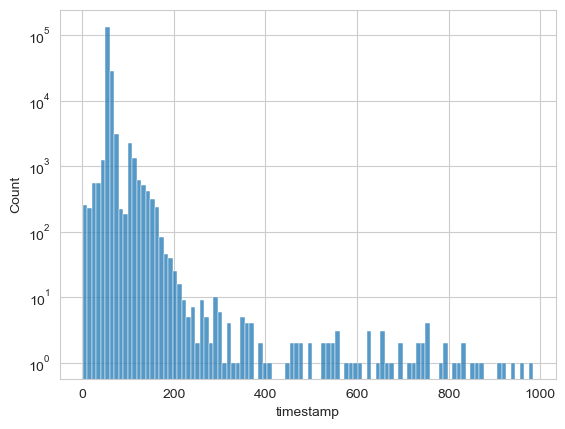

In [95]:
import seaborn as sns
print('Mode:', ts_diff.mode()[0])
sns.histplot(ts_diff[ts_diff < 1e3], bins=100)
# sns.histplot(ts_diff[ ts_diff.between(1e3, 1e4) ], bins=100)
# sns.histplot(ts.diff(), bins=100);
plt.yscale('log');

In [96]:
# 5min
mask = ts_diff > 300
start = ts.timestamp[mask.shift(-1, fill_value=False)]
end = ts.timestamp[mask]

In [97]:
pd.concat([start + 1, end - 1]).sort_index()

38075     1699836306
38076     1699843354
39194     1699907594
39195     1699918413
55631     1700853288
             ...    
177477    1714736270
177488    1714736990
177489    1714737517
177490    1714737581
177491    1714738696
Name: timestamp, Length: 222, dtype: uint32

In [98]:
nan_intervals = ts[mask.shift(-1) | mask].timestamp
nan_intervals

38075     1699836305
38076     1699843355
39194     1699907593
39195     1699918414
55631     1700853287
             ...    
177477    1714736271
177488    1714736989
177489    1714737518
177490    1714737580
177491    1714738697
Name: timestamp, Length: 210, dtype: uint32

In [99]:
nan_df = pd.DataFrame({
    'cost': None,
    'timestamp': nan_intervals
})
nan_df.cost.astype('UInt16')

38075     <NA>
38076     <NA>
39194     <NA>
39195     <NA>
55631     <NA>
          ... 
177477    <NA>
177488    <NA>
177489    <NA>
177490    <NA>
177491    <NA>
Name: cost, Length: 210, dtype: UInt16

In [100]:
with sqlite3.connect('../vast.db') as conn:
    eod = pd.read_sql(
        f'''
        SELECT machine_id, verification, timestamp FROM eod_ts    
        ''', 
        conn, 
        index_col='machine_id',
        dtype={
            'machine_id': 'uint16',
            'verification': 'uint8',
            'timestamp': 'uint32',            
        })
    
eod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386307 entries, 14326 to 3056
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   verification  386307 non-null  uint8 
 1   timestamp     386307 non-null  uint32
dtypes: uint32(1), uint8(1)
memory usage: 2.6 MB


In [101]:
eod = eod.groupby('machine_id').apply(drop_consecutives, cols='verification').reset_index(level=0, drop=True)
eod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28230 entries, 63 to 22982
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   verification  28230 non-null  uint8 
 1   timestamp     28230 non-null  uint32
dtypes: uint32(1), uint8(1)
memory usage: 193.0 KB


In [102]:
eod['date'] = pd.to_datetime(eod.timestamp, unit='s').dt.date

In [103]:
mask = eod.groupby('machine_id').apply(lambda x: (x.verification == 0) & (x.verification.shift(-1) == 1)).reset_index(drop=True)

In [104]:
mask = mask.values | mask.shift(fill_value=False).values
mask

array([ True,  True, False, ..., False, False, False])

In [105]:
eod[mask]

,verification,timestamp,date
machine_id,,,
63,0,1697699070,2023-10-19
63,1,1697913735,2023-10-21
1488,0,1697703054,2023-10-19
1488,1,1697913735,2023-10-21
3042,0,1712928248,2024-04-12
...,...,...,...
22893,1,1714587913,2024-05-01
22894,0,1714501037,2024-04-30
22894,1,1714594611,2024-05-01


In [106]:
eod_uniq = eod[mask].groupby('machine_id').apply(lambda x: x.drop_duplicates('verification')).reset_index(level=0, drop=True)

<Axes: >

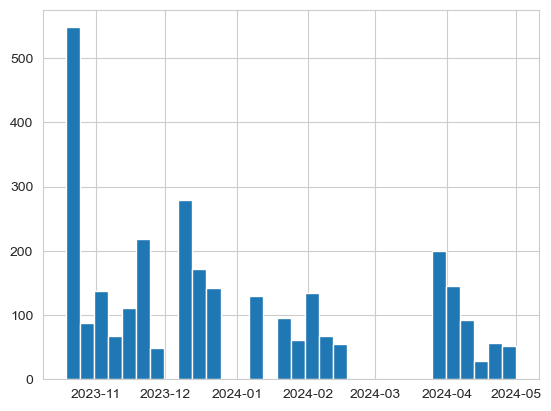

In [107]:
eod_uniq.date.hist(bins=32)

In [108]:
verif_id = eod[mask].index.drop_duplicates()

In [109]:
hw_uniq = hw.reset_index().drop_duplicates('machine_id').set_index('machine_id')
hw_uniq

,num_gpus,gpu_name,mobo_name,cpu_name,timestamp,datetime
machine_id,,,,,,
63,1,RTX 2080 Ti,X9DRi,Xeon® E5-2630 0,1697699070,2023-10-19 07:04:30
162,4,RTX 2080 Ti,X399 GAMING PRO CARBON AC,AMD Ryzen Threadripper 1950X 16-Core Processor,1697699070,2023-10-19 07:04:30
274,8,GTX 1070,X9DRX,Xeon® E5-2650 v2,1697699070,2023-10-19 07:04:30
275,8,GTX 1070,X9DRX,Xeon® E5-2650 v2,1697699070,2023-10-19 07:04:30
283,6,GTX 1070,X9DRX,Xeon® E5-2658 v2,1697699070,2023-10-19 07:04:30
...,...,...,...,...,...,...
22974,1,RTX 4090,,Xeon® E5-2682 v4,1714727902,2024-05-03 09:18:22
22975,1,RTX 4090,,,1714731284,2024-05-03 10:14:44
22980,1,RTX 4090,,,1714735089,2024-05-03 11:18:09


In [110]:
def calc_verif_time(df):
    df['verif_duration'] = df.iloc[-1, 2] - df.iloc[0, 2]
    df['verif_date'] = df.iloc[-1, 2]
    return df[-1:]
    

# verif_time = eod[mask].groupby('machine_id').apply(lambda x: x.iloc[-1, 2] - x.iloc[0, 2])
verif = eod[mask].groupby('machine_id').apply(calc_verif_time).reset_index(level=0, drop=True)
verif

,verification,timestamp,date,verif_duration,verif_date
machine_id,,,,,
63,1,1697913735,2023-10-21,2 days,2023-10-21
1488,1,1697913735,2023-10-21,2 days,2023-10-21
3042,1,1712960721,2024-04-12,0 days,2024-04-12
3752,1,1702495767,2023-12-13,55 days,2023-12-13
4840,1,1711526112,2024-03-27,160 days,2024-03-27
...,...,...,...,...,...
22840,1,1714594786,2024-05-01,2 days,2024-05-01
22843,1,1714594786,2024-05-01,2 days,2024-05-01
22892,1,1714594786,2024-05-01,1 days,2024-05-01


In [111]:
hw_uniq.loc[verif.index, 'verif_date'] = verif.verif_date
hw_uniq.loc[verif.index, 'verif_duration'] = verif.verif_duration

In [112]:
hw_uniq.loc[verif_id].groupby('gpu_name')['verif_duration'].mean()

gpu_name
A10                      13 days 12:00:00
A100 PCIE       7 days 15:09:28.421052631
A100 SXM4                 5 days 12:00:00
A100X                     1 days 00:00:00
A40            15 days 11:49:15.223880597
GH200 SXM                 5 days 00:00:00
GTX 1060                 40 days 00:00:00
GTX 1070                 45 days 12:00:00
GTX 1070 Ti              46 days 00:00:00
GTX 1080 Ti              64 days 20:00:00
H100 PCIE                17 days 02:24:00
H100 SXM                  5 days 12:00:00
L40                       3 days 00:00:00
L40S                     22 days 00:00:00
Q RTX 8000                7 days 00:00:00
RTX 2070                  9 days 00:00:00
RTX 2070S                 2 days 00:00:00
RTX 2080 Ti              51 days 05:20:00
RTX 3060       43 days 22:22:42.162162162
RTX 3060 Ti    24 days 05:32:18.461538461
RTX 3070                 58 days 00:00:00
RTX 3070 Ti              10 days 00:00:00
RTX 3080                 36 days 00:00:00
RTX 3080 Ti              

In [116]:
hw_uniq.dropna().query('gpu_name == "RTX 4090" and num_gpus == 1')[['verif_duration', 'verif_date', 'mobo_name', 'cpu_name']]

,verif_duration,verif_date,mobo_name,cpu_name
machine_id,,,,
10398,10 days,2023-11-20,X99,Xeon® E5-2698 v3
11213,13 days,2023-12-20,TUF GAMING X570,AMD Ryzen 9 5900X 12-Core Processor
12031,24 days,2023-12-20,ROMED8,AMD EPYC 7B13 64-Core Processor
12237,62 days,2023-12-20,ROG STRIX X570,AMD Ryzen 7 5800X 8-Core Processor
12490,160 days,2024-03-27,Z690 UD DDR4,12th Gen Core™ i7-12700K
...,...,...,...,...
20121,5 days,2024-04-01,X399 SLI PLUS,AMD Ryzen Threadripper 1920X 12-Core Processor
20755,8 days,2024-04-04,,Xeon® Gold 6146
21527,7 days,2024-04-12,ROG STRIX X570,AMD Ryzen 9 5950X 16-Core Processor


In [118]:
eod.loc[16571]

,verification,timestamp,date
machine_id,,,
16571,0,1702043408,2023-12-08
16571,1,1712960437,2024-04-12
16571,0,1712960495,2024-04-12
16571,1,1712960721,2024-04-12
16571,2,1713292737,2024-04-16
16571,1,1713808565,2024-04-22
16571,2,1713812349,2024-04-22
16571,1,1713812405,2024-04-22
16571,2,1713812468,2024-04-22


In [119]:
hw_uniq.verif_date.value_counts()

verif_date
2023-11-20    184
2023-12-18    141
2023-12-20    132
2023-10-21    128
2024-03-27    114
             ... 
2024-02-08      1
2024-04-30      1
2023-10-26      1
2024-04-03      1
2024-01-27      1
Name: count, Length: 77, dtype: int64